# Object Detection 



Created on: 7/22/2021







# Prepare Dataset for Object Detector
Preparing dataset for object detection is slightly difference and more difficult than image prediction.


There are generally two ways to load a dataset for ObjectDetector:

* Load an existing object detection dataset, in VOC or COCO formats, downloaded or exported by other labeling tools.

* Manually convert raw annotations in any format, knowing this you will be able to deal with arbitrary dataset format.

In [1]:
!pip install --pre autogluon 
!pip install autogluon
%matplotlib inline
import autogluon.core as ag
from autogluon.vision import ObjectDetector


     |████████████████████████████████| 52 kB 397 kB/s 
     |████████████████████████████████| 49 kB 1.8 MB/s 
     |████████████████████████████████| 341 kB 1.7 MB/s 
     |████████████████████████████████| 268 kB 7.5 MB/s 
     |████████████████████████████████| 206 kB 7.5 MB/s 
     |████████████████████████████████| 81 kB 4.2 MB/s 
     |████████████████████████████████| 950 kB 8.0 MB/s 
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - \ | / - \ done
     |████████████████████████████████| 119 kB 8.8 MB/s 
     |████████████████████████████████| 2.2 MB 8.9 MB/s 
     |████████████████████████████████| 188 kB 11.9 MB/s 
     |████████████████████████████████| 67.3 MB 18 kB/s 
     |████████████████████████████████| 157 kB 66.6 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████████████████████████| 54 kB 1.4 MB/s 
     |███████████

/opt/conda/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Load an existing object detection dataset

Pascal [VOC](http://host.robots.ox.ac.uk/pascal/VOC/) and MS [COCO](https://cocodataset.org/#home) are two most popular data format for object detection. Most public available object detection datasets follow either one of these two formats. To distinguish these two formats, you can either refer to the labeling tool or check the folder structure. Usually annotations in VOC format are individual xml files, while COCO format use a single json file to store all annotations.

In [2]:
url = 'https://autogluon.s3.amazonaws.com/datasets/tiny_motorbike.zip'
dataset_train = ObjectDetector.Dataset.from_voc(url, splits='trainval')
# or load from coco format, skip as it's too big to download
# dataset_train = ObjectDetector.Dataset.from_coco(annotation_json_file, root='/path/to/root')

21273KB [00:00, 35099.57KB/s]                           


tiny_motorbike/
├── Annotations/
├── ImageSets/
└── JPEGImages/


# Manually convert any format to autogluon object detector dataset

In the following section, we will use a single image and add annotations manually for all three major objects.




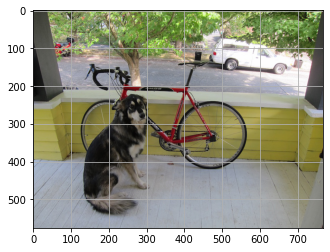

In [3]:
ag.utils.download('https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg', path='dog.jpg')
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('dog.jpg')
imgplot = plt.imshow(img)
plt.grid()
plt.show()

With the grid on, we can roughly annotate this image like this:

In [4]:
import pandas as pd

class NaiveDetectionGT:
    def __init__(self, image):
        self._objects = []
        self.image = image
        img = mpimg.imread('dog.jpg')
        self.w = img.shape[1]
        self.h = img.shape[0]

    def add_object(self, name, xmin, ymin, xmax, ymax, difficult=0):
        self._objects.append({'image': self.image, 'class': name,
                              'xmin': xmin / self.w, 'ymin': ymin / self.h,
                              'xmax': xmax / self.w, 'ymax': ymax / self.h, 'difficult': difficult})

    @property
    def df(self):
        return pd.DataFrame(self._objects)

gt = NaiveDetectionGT('dog.jpg')
gt.add_object('dog', 140, 220, 300, 540)
gt.add_object('bicycle', 120, 140, 580, 420)
gt.add_object('car', 460, 70, 680, 170)
df = gt.df
df

,image,class,xmin,ymin,xmax,ymax,difficult
0,dog.jpg,dog,0.182292,0.381944,0.390625,0.937500,0
1,dog.jpg,bicycle,0.156250,0.243056,0.755208,0.729167,0
2,dog.jpg,car,0.598958,0.121528,0.885417,0.295139,0


The df is a valid dataset and can be used by ObjectDetector.fit function. Internally it will be converted to object detection dataset, or you can manually convert it.

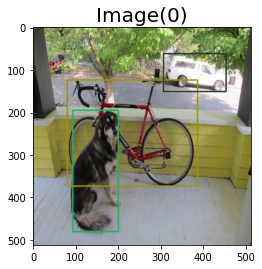

In [5]:
dataset = ObjectDetector.Dataset(df, classes=df['class'].unique().tolist())
dataset.show_images(nsample=1, ncol=1)

# Object Detection - AutoGluon

Object detection is the process of identifying and localizing objects in an image and is an important task in computer vision. 

Our goal is to detect motorbike in images by [YOLOv3](https://pjreddie.com/media/files/papers/YOLOv3.pdf) model. A tiny dataset is collected from VOC dataset, which only contains the motorbike category. The model pretrained on the COCO dataset is used to fine-tune our small dataset. With the help of AutoGluon, we are able to try many models with different hyperparameters automatically, and return the best one as our final model.

To start, import autogluon.vision and ObjectDetector:

In [6]:
import autogluon.core as ag
from autogluon.vision import ObjectDetector

# Tiny_motorbike Dataset

We collect a toy dataset for detecting motorbikes in images. From the VOC dataset, images are randomly selected for training, validation, and testing - 120 images for training, 50 images for validation, and 50 for testing. This tiny dataset follows the same format as VOC.

In [7]:
data = '../input/tiny-dataset/tiny_motorbike'
dataset_train = ObjectDetector.Dataset.from_voc(data, splits='trainval')
dataset_train

,image,rois,image_attr
0,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'motorbike', 'xmin': 0.702, 'ymin':...","{'width': 500.0, 'height': 375.0}"
1,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'motorbike', 'xmin': 0.117117117117...","{'width': 333.0, 'height': 500.0}"
2,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'person', 'xmin': 0.102, 'ymin': 0....","{'width': 500.0, 'height': 432.0}"
3,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'motorbike', 'xmin': 0.226, 'ymin':...","{'width': 500.0, 'height': 375.0}"
4,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'motorbike', 'xmin': 0.357357357357...","{'width': 333.0, 'height': 500.0}"
...,...,...,...
165,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'motorbike', 'xmin': 0.0, 'ymin': 0...","{'width': 500.0, 'height': 333.0}"
166,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'person', 'xmin': 0.408, 'ymin': 0....","{'width': 500.0, 'height': 375.0}"
167,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'person', 'xmin': 0.382, 'ymin': 0....","{'width': 500.0, 'height': 375.0}"
168,../input/tiny-dataset/tiny_motorbike/JPEGImage...,"[{'class': 'motorbike', 'xmin': 0.272, 'ymin':...","{'width': 500.0, 'height': 375.0}"


# Fit Models by AutoGluon

In this section, we demonstrate how to apply AutoGluon to fit our detection models. We use mobilenet as the backbone for the YOLOv3 model. Two different learning rates are used to fine-tune the network. The best model is the one that obtains the best performance on the validation dataset. You can also try using more networks and hyperparameters to create a larger searching space.

We fit a classifier using AutoGluon as follows. In each experiment (one trial in our searching space), we train the model for 5 epochs to avoid bursting our tutorial runtime.

In [8]:
time_limit = 60*30  # at most 0.5 hour
detector = ObjectDetector()
hyperparameters = {'epochs': 5, 'batch_size': 8}
hyperparamter_tune_kwargs={'num_trials': 2}
detector.fit(dataset_train, time_limit=time_limit, hyperparameters=hyperparameters, hyperparamter_tune_kwargs=hyperparamter_tune_kwargs)

100%|██████████| 82589/82589 [00:04<00:00, 18324.74KB/s]


9624KB [00:01, 7641.47KB/s]                           


In [9]:
dataset_test = ObjectDetector.Dataset.from_voc(data, splits='test')

test_map = detector.evaluate(dataset_test)
print("mAP on test dataset: {}".format(test_map[1][-1]))

mAP on test dataset: 0.08191541079241614


Below, we randomly select an image from test dataset and show the predicted class, box and probability over the origin image, stored in predict_class, predict_rois and predict_score columns, respectively. You can interpret predict_rois as a dict of (xmin, ymin, xmax, ymax) proportional to original image size.

In [10]:
image_path = dataset_test.iloc[0]['image']
result = detector.predict(image_path)
print(result)

   predict_class  predict_score  \
0      motorbike       0.994950   
1         person       0.964762   
2            car       0.284216   
3      motorbike       0.167471   
4         person       0.118077   
..           ...            ...   
95           car       0.036268   
96        person       0.036217   
97           car       0.036178   
98        person       0.036096   
99        person       0.036070   

                                         predict_rois  
0   {'xmin': 0.32438328862190247, 'ymin': 0.402174...  
1   {'xmin': 0.3839596211910248, 'ymin': 0.2828721...  
2   {'xmin': 0.006159716751426458, 'ymin': 0.66775...  
3   {'xmin': 0.70685875415802, 'ymin': 0.372331827...  
4   {'xmin': 0.4021448791027069, 'ymin': 0.3183985...  
..                                                ...  
95  {'xmin': 0.2343703955411911, 'ymin': 0.7334546...  
96  {'xmin': 0.3236338794231415, 'ymin': 0.7802318...  
97  {'xmin': 0.13247768580913544, 'ymin': 0.699803...  
98  {'xmin': 0.4942

Prediction with multiple images is permitted:

In [11]:
bulk_result = detector.predict(dataset_test)
print(bulk_result)

     predict_class  predict_score  \
0        motorbike       0.994950   
1           person       0.964762   
2              car       0.284216   
3        motorbike       0.167471   
4           person       0.118077   
...            ...            ...   
4676        person       0.031957   
4677        person       0.031874   
4678        person       0.031749   
4679        person       0.031683   
4680        person       0.031647   

                                           predict_rois  \
0     {'xmin': 0.32438328862190247, 'ymin': 0.402174...   
1     {'xmin': 0.3839596211910248, 'ymin': 0.2828721...   
2     {'xmin': 0.006159716751426458, 'ymin': 0.66775...   
3     {'xmin': 0.70685875415802, 'ymin': 0.372331827...   
4     {'xmin': 0.4021448791027069, 'ymin': 0.3183985...   
...                                                 ...   
4676  {'xmin': 0.3300017714500427, 'ymin': 0.4472578...   
4677  {'xmin': 0.08467146754264832, 'ymin': 0.382369...   
4678  {'xmin': 0.0223420

# Reference :
This section provides more resources on the topic if you are looking to go deeper.



* https://github.com/awslabs/autogluon